In [7]:
# importing packages and modules
import numpy as np
import matplotlib as mpl
import scipy.stats as stats
from scipy.optimize import minimize, check_grad
from io_utils import *
from utils import *
from plotting_utils import *
from analysis_utils import *
import dynamic_glmhmm
from scipy.stats import multivariate_normal, norm
sns.set_context("talk")

colormap = ['tab:purple','tab:pink','tab:cyan','yellowgreen', 'olive']
colorsStates = ['tab:orange','tab:blue','tab:green','tab:purple', 'tab:brown']
myFeatures = [['bias','stimulus', 'previous choice', 'previous reward'],['bias','contrast left','contrast right', 'previous choice', 'previous reward']]
ibl_data_path = '../data_IBL'
# dfAll = pd.read_csv(ibl_data_path + '/Ibl_processed.csv')
dfAll = pd.read_csv(ibl_data_path + '/IBL_processed_extra.csv')

labChosen =  ['angelakilab','churchlandlab','wittenlab']
subjectsAll = []
for lab in labChosen:
    subjects = np.unique(dfAll[dfAll['lab'] == lab]['subject']).tolist()
    subjectsAll = subjectsAll + subjects

# missing data
if ('NYU-01' in subjectsAll):
    subjectsAll.remove('NYU-01')
if ('NYU-06' in subjectsAll):
    subjectsAll.remove('NYU-06')
if ('CSHL_007' in subjectsAll):
    subjectsAll.remove('CSHL_007')
if ('CSHL049' in subjectsAll):
    subjectsAll.remove('CSHL049')
if ('CSHL024' in subjectsAll):
    subjectsAll.remove('CSHL024')

In [25]:
dfAll.head()

,lab,subject,date,session,contrastLeft,contrastRight,choice,probabilityLeft,feedbackType,rewardVolume,pupil_mean1,pupil_mean2,RT
0,churchlandlab,CSHL075,2020-10-15,4,1.00,0.000,1.0,0.5,1.0,1.5,10.816400,10.687351,0.272443
1,churchlandlab,CSHL075,2020-10-15,4,0.00,0.125,-1.0,0.5,1.0,1.5,10.425780,10.237078,2.133587
2,churchlandlab,CSHL075,2020-10-15,4,0.25,0.000,-1.0,0.5,-1.0,0.0,10.290754,10.185414,5.068065
3,churchlandlab,CSHL075,2020-10-15,4,0.00,1.000,-1.0,0.5,1.0,1.5,9.704977,7.278451,0.251100
4,churchlandlab,CSHL075,2020-10-15,4,0.00,0.000,-1.0,0.5,-1.0,0.0,9.776015,10.017833,2.453139


In [24]:
dfAll.loc[dfAll['contrastLeft'].isna(),'contrastLeft'] = 0 
dfAll.loc[dfAll['contrastRight'].isna(), 'contrastRight'] = 0 

In [4]:
dfAll.dtypes

contrastLeft       float64
contrastRight      float64
choice             float64
feedbackType       float64
probabilityLeft    float64
lab                 object
subject             object
date                object
session            float64
correctSide        float64
response_times     float64
RT                 float64
dtype: object

In [9]:
import pandas as pd

datasets = pd.read_parquet("datasets.pqt")
print(datasets.shape)
print(datasets.columns.tolist())


datasets = pd.read_parquet("sessions.pqt")
print(datasets.shape)
print(datasets.columns.tolist())

(14366, 9)
['file_size', 'hash', 'default_revision', 'qc', 'exists_flatiron', 'exists_aws', 'exists', 'session_path', 'rel_path']
(6488, 6)
['lab', 'subject', 'date', 'number', 'task_protocol', 'projects']


In [10]:
# look at the distribution of the change in weights, see it correlates with time spent in each state, etc.

In [11]:
from one.api import ONE
ONE.setup(base_url='https://openalyx.internationalbrainlab.org', silent=True)
ONE.cache_clear()
one = ONE(password='international')
# 'left', 'right' or 'body'
for subject in subjectsAll:
    try:
        eids, infos = one.search(details=True, subject=subject) #, task_protocol='training')
        video_features = one.load_object(eids[0], f'bodyCamera', collection='alf')
        print(video_features)
    except Exception as e:
        print(f'Error loading trials for {eid}: {e}')

Connected to https://openalyx.internationalbrainlab.org as user "intbrainlab"
Error loading trials for 4ecb5d24-f5cc-402c-be28-9d0f7cb14b3a: bodyCamera 
 The ALF object was not found.  This may occur if the object or namespace or incorrectly formatted e.g. the object "_ibl_trials.intervals.npy" would be found with the filters `object="trials", namespace="ibl"` 
Error loading trials for 4ecb5d24-f5cc-402c-be28-9d0f7cb14b3a: bodyCamera 
 The ALF object was not found.  This may occur if the object or namespace or incorrectly formatted e.g. the object "_ibl_trials.intervals.npy" would be found with the filters `object="trials", namespace="ibl"` 
Error loading trials for 4ecb5d24-f5cc-402c-be28-9d0f7cb14b3a: bodyCamera 
 The ALF object was not found.  This may occur if the object or namespace or incorrectly formatted e.g. the object "_ibl_trials.intervals.npy" would be found with the filters `object="trials", namespace="ibl"` 
Error loading trials for 4ecb5d24-f5cc-402c-be28-9d0f7cb14b3a: b

KeyboardInterrupt: 

In [4]:
from one.api import ONE
ONE.setup(base_url='https://openalyx.internationalbrainlab.org', silent=True)
ONE.cache_clear()
one = ONE(password='international')

Connected to https://openalyx.internationalbrainlab.org as user "intbrainlab"


In [5]:
def load_object_if_exists(eid, obj, collection='alf', attributes=None):
    # ALF files for an object are typically named like: _ibl_<object>.<attribute>.<ext>
    # e.g. _ibl_rightCamera.times.npy, _ibl_rightCamera.dlc.pqt
    prefix = f"_ibl_{obj}."
    dsets = one.list_datasets(eid, collection=collection, filename=prefix + "*")
    if not dsets:
        return None

    if attributes is None:
        return one.load_object(eid, obj, collection=collection)
    else:
        return one.load_object(eid, obj, collection=collection, attribute=attributes)

eid = '4ecb5d24-f5cc-402c-be28-9d0f7cb14b3a'
cam = load_object_if_exists(eid, 'rightCamera', collection='alf', attributes=['times', 'dlc'])
trial_data = one.load_object(eid, 'trials')
print("cam is None?", cam is None)
if cam is not None:
    print("Loaded keys:", cam.keys())

/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "2022-01-31", ""
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


cam is None? False
Loaded keys: dict_keys(['dlc', 'times'])


603007
Index(['nose_tip_x', 'nose_tip_y', 'nose_tip_likelihood', 'pupil_top_r_x',
       'pupil_top_r_y', 'pupil_top_r_likelihood', 'pupil_right_r_x',
       'pupil_right_r_y', 'pupil_right_r_likelihood', 'pupil_bottom_r_x',
       'pupil_bottom_r_y', 'pupil_bottom_r_likelihood', 'pupil_left_r_x',
       'pupil_left_r_y', 'pupil_left_r_likelihood', 'paw_l_x', 'paw_l_y',
       'paw_l_likelihood', 'paw_r_x', 'paw_r_y', 'paw_r_likelihood',
       'tube_top_x', 'tube_top_y', 'tube_top_likelihood', 'tube_bottom_x',
       'tube_bottom_y', 'tube_bottom_likelihood', 'tongue_end_l_x',
       'tongue_end_l_y', 'tongue_end_l_likelihood', 'tongue_end_r_x',
       'tongue_end_r_y', 'tongue_end_r_likelihood'],
      dtype='object')
603007
dict_keys(['goCueTrigger_times', 'intervals_bpod', 'quiescencePeriod', 'stimOffTrigger_times', 'stimOff_times', 'stimOnTrigger_times', 'goCue_times', 'response_times', 'choice', 'stimOn_times', 'contrastLeft', 'contrastRight', 'probabilityLeft', 'feedback_times',

(0.0, 10000.0)

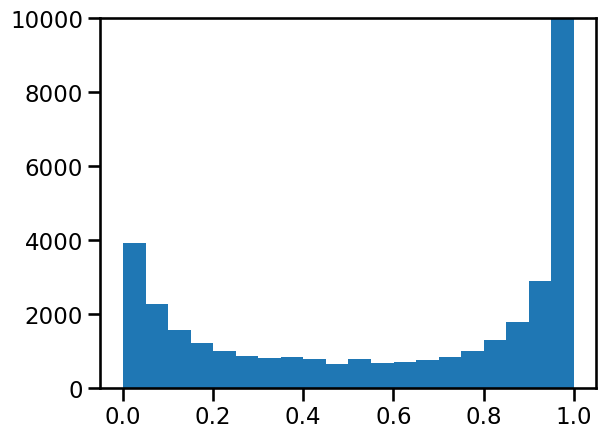

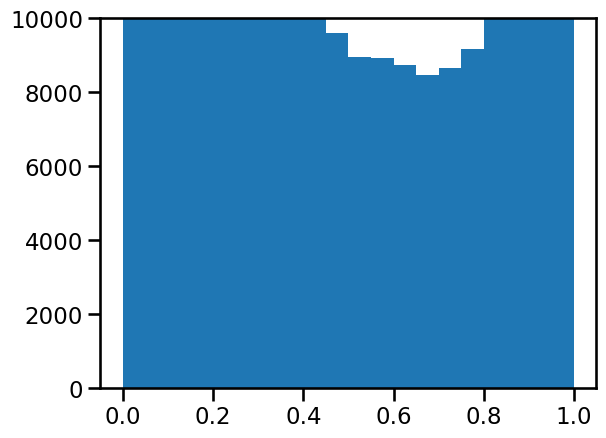

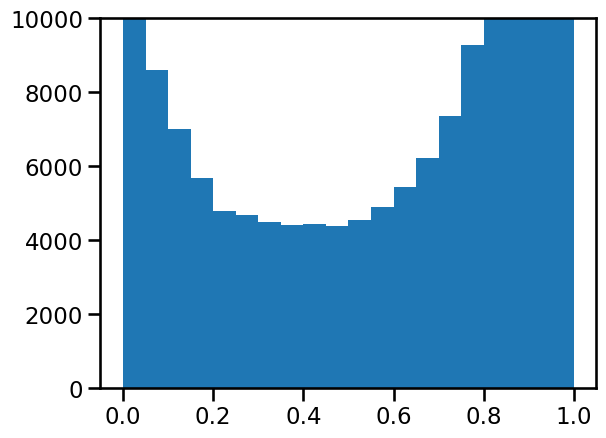

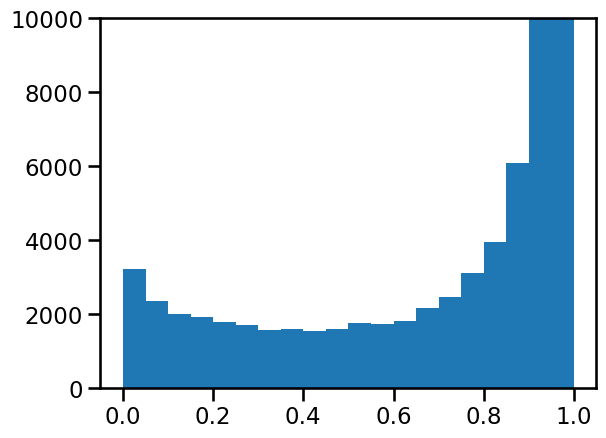

In [6]:
print(len(cam['dlc'].index.tolist()))
print(cam['dlc'].keys())
print(len(cam['times']))
# print(cam['times'][-50:])
print(trial_data.keys())
print(len(trial_data['choice']))
print(trial_data['intervals'][-1])
print(trial_data['stimOn_times'][-1])
print(trial_data['goCue_times'][-1])
print(trial_data['response_times'][-1])
print(trial_data['stimOff_times'][-1])
# print(trial_data['stimOn_times'][-1])
# print(trial_data['stimOff_times'][-1])
fig, axes = plt.subplots()
axes.hist(cam['dlc']['pupil_top_r_likelihood'], bins=20)
axes.set_ylim(0,10000)
fig, axes = plt.subplots()
axes.hist(cam['dlc']['pupil_bottom_r_likelihood'], bins=20)
axes.set_ylim(0,10000)
fig, axes = plt.subplots()
axes.hist(cam['dlc']['pupil_right_r_likelihood'], bins=20)
axes.set_ylim(0,10000)
fig, axes = plt.subplots()
axes.hist(cam['dlc']['pupil_left_r_likelihood'], bins=20)
axes.set_ylim(0,10000)


In [17]:
def load_IBL_behavioral_data():
    '''
    Load data from IBL database for a given protocol, into a pandas dataframe.
    Select the `trainable` the subjects that moved to biasedChoiceWorld, thus attained status `Trained 1b`. 
    Args:
        protocol: str, the protocol to load data from. Select from ['training', 'no_curriculum', 'training_biasedChoiceWorld']
    returns: 
        entries: pd.DataFrame, the data from the IBL database, with columns:
            ['lab', 'subject', 'date', 'contrastRight', 'choice', 'probabilityLeft', 'feedbackType', 'rewardVolume', 'contrastLeft']
    '''
    from one.api import ONE
    ONE.setup(base_url='https://openalyx.internationalbrainlab.org', silent=True)
    ONE.cache_clear()
    one = ONE(password='international')
    # eids, infos = one.search(details=True, subject=subject) #, task_protocol='training')

    # eids, infos = one.search(subject='ibl_witten_12', details=True)

    eids, infos = one.search(details=True, lab='churchlandlab')
    # eid = '4ecb5d24-f5cc-402c-be28-9d0f7cb14b3a'

    # dfsub = dfAll[dfAll['subject']==subject]

    # Select keys for trial data that are not time dependent (e.g. 'goCue_times')
    keys = ['contrastLeft', 'contrastRight', 'choice', 'probabilityLeft', 'feedbackType', 'rewardVolume']
    keys_dlc = ['pupil_top_r_x',
       'pupil_top_r_y', 'pupil_top_r_likelihood', 'pupil_right_r_x',
       'pupil_right_r_y', 'pupil_right_r_likelihood', 'pupil_bottom_r_x',
       'pupil_bottom_r_y', 'pupil_bottom_r_likelihood', 'pupil_left_r_x',
       'pupil_left_r_y', 'pupil_left_r_likelihood']

    def check_keys(trial_data) -> bool:
        return np.all([key in trial_data.keys() for key in keys])

    # Compile data into a pandas dataframe
    entries = {'lab': [], 'subject': [], 'date': [], 'session': []}
    for key in keys:
        entries[key] = []
    entries['pupil_mean1'] = []
    entries['pupil_mean2'] = []
    entries['RT'] = []
   

    error_animals = []
    for eid, info in zip(eids, infos):
        print(eid, info)
        cam = load_object_if_exists(eid, 'rightCamera', collection='alf', attributes=['times', 'dlc'])
        if cam is not None:
            try:
                
                # trial_data = one.load_object(eid) #, 'trials')
                trial_data = one.load_object(eid, 'trials')
                assert check_keys(trial_data), f'Keys missing.'
             

                # print("rows:", len(idx), "trial_data:", len(rt))
                    
                for t in range(len(trial_data['choice'])):
                    # entries['lab'].append('lab')
                    # entries['subject'].append('subject')
                    # entries['date'].append(str('date'))
                    # entries['session'].append('number')
                    entries['lab'].append(info['lab'])
                    entries['subject'].append(info['subject'])
                    entries['date'].append(str(info['date']))
                    entries['session'].append(info['number'])

                    idx1 = (cam['times'] > trial_data['intervals'][t][0]) & (cam['times'] < trial_data['intervals'][t][1]) 
                    idx2 = (cam['times'] > trial_data['stimOn_times'][t]) & (cam['times'] < trial_data['response_times'][t])
                    # idx3 = (cam['times'] > trial_data['stimOn_times'][t]) & (cam['times'] < trial_data['stimOff_times'])

                    # trial info 
                    for key in keys:
                        entries[key].append(float(trial_data[key][t]))

                    try:
                        entries['RT'].append(trial_data['response_times'][t] - trial_data['goCue_times'][t])
                    except Exception:
                        entries['RT'].append(np.nan)

                    try:
                        idx1 = (cam['times'] > trial_data['intervals'][t][0]) & (cam['times'] < trial_data['intervals'][t][1])
                        idx2 = (cam['times'] > trial_data['stimOn_times'][t]) & (cam['times'] < trial_data['response_times'][t])

                        good_height = (cam['dlc']['pupil_top_r_likelihood'] > 0.7) & (cam['dlc']['pupil_bottom_r_likelihood'] > 0.7)
                        good_width  = (cam['dlc']['pupil_right_r_likelihood'] > 0.7) & (cam['dlc']['pupil_left_r_likelihood'] > 0.7)

                        pupil_height1 = np.nanmean(np.linalg.norm(
                            np.array(cam['dlc'].loc[idx1 & good_height][['pupil_top_r_x','pupil_top_r_y']]) -
                            np.array(cam['dlc'].loc[idx1 & good_height][['pupil_bottom_r_x','pupil_bottom_r_y']]),
                            axis=1
                        ))
                        pupil_width1 = np.nanmean(np.linalg.norm(
                            np.array(cam['dlc'].loc[idx1 & good_width][['pupil_right_r_x','pupil_right_r_y']]) -
                            np.array(cam['dlc'].loc[idx1 & good_width][['pupil_left_r_x','pupil_left_r_y']]),
                            axis=1
                        ))
                        pupil_height2 = np.nanmean(np.linalg.norm(
                            np.array(cam['dlc'].loc[idx2 & good_height][['pupil_top_r_x','pupil_top_r_y']]) -
                            np.array(cam['dlc'].loc[idx2 & good_height][['pupil_bottom_r_x','pupil_bottom_r_y']]),
                            axis=1
                        ))
                        pupil_width2 = np.nanmean(np.linalg.norm(
                            np.array(cam['dlc'].loc[idx2 & good_width][['pupil_right_r_x','pupil_right_r_y']]) -
                            np.array(cam['dlc'].loc[idx2 & good_width][['pupil_left_r_x','pupil_left_r_y']]),
                            axis=1
                        ))

                        entries['pupil_mean1'].append(np.nanmean(np.array([pupil_height1, pupil_width1])))
                        entries['pupil_mean2'].append(np.nanmean(np.array([pupil_height2, pupil_width2])))

                    except Exception:
                        # critical: keep lengths aligned
                        entries['pupil_mean1'].append(np.nan)
                        entries['pupil_mean2'].append(np.nan)
                    
                    # entries['RT'].append(trial_data['response_times'][t]-trial_data['goCue_times'][t])
                    
                    # # masking low likelihood frames
                    # good_height = (cam['dlc']['pupil_top_r_likelihood'] > 0.7) & (cam['dlc']['pupil_bottom_r_likelihood'] > 0.7)
                    # good_width = (cam['dlc']['pupil_right_r_likelihood'] > 0.7) & (cam['dlc']['pupil_left_r_likelihood'] > 0.7)
                    
                    # pupil_height1 = np.nanmean(np.linalg.norm(np.array(cam['dlc'].loc[idx1 & good_height][['pupil_top_r_x','pupil_top_r_y']]) - np.array(cam['dlc'].loc[idx1 & good_height][['pupil_bottom_r_x','pupil_bottom_r_y']]), axis=1))
                    # pupil_width1 = np.nanmean(np.linalg.norm(np.array(cam['dlc'].loc[idx1 & good_width][['pupil_right_r_x','pupil_right_r_y']]) - np.array(cam['dlc'].loc[idx1 & good_width][['pupil_left_r_x','pupil_left_r_y']]), axis=1))
                    # # print(pupil_height1)
                    # # print(pupil_width1)
                    # pupil_height2 = np.nanmean(np.linalg.norm(np.array(cam['dlc'].loc[idx2 & good_height][['pupil_top_r_x','pupil_top_r_y']]) - np.array(cam['dlc'].loc[idx2 & good_height][['pupil_bottom_r_x','pupil_bottom_r_y']]), axis=1))
                    # pupil_width2 = np.nanmean(np.linalg.norm(np.array(cam['dlc'].loc[idx2 & good_width][['pupil_right_r_x','pupil_right_r_y']]) - np.array(cam['dlc'].loc[idx2 & good_width][['pupil_left_r_x','pupil_left_r_y']]), axis=1))

                    # entries['pupil_mean1'].append(np.nanmean(np.array([pupil_height1,pupil_width1])))
                    # entries['pupil_mean2'].append(np.nanmean(np.array([pupil_height2,pupil_width2])))
        
            except Exception as e: # Catch any errors, leave out the data
                print(f'Error loading trials for {eid}: {e}')
                # error_animals.append(info['subject'])
                continue

    for k, v in entries.items():
        print(k, len(v))

    entries_df = pd.DataFrame(entries)
    # entries_df = entries_df.fillna(0) # NaNs are on the contrast information, which is 0 when not present
    
    return entries_df # , error_animals
entries_df = load_IBL_behavioral_data()
# for subject in subjectsAll[:]:
#     entries_df, error_animals =  load_IBL_behavioral_data()

Connected to https://openalyx.internationalbrainlab.org as user "intbrainlab"
f45e30cf-12aa-4fa0-8248-f9f885dfa9ef {'id': 'f45e30cf-12aa-4fa0-8248-f9f885dfa9ef', 'subject': 'CSHL075', 'start_time': '2020-10-15T09:01:07', 'number': 4, 'lab': 'churchlandlab', 'projects': ['churchland_learninglifespan'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/f45e30cf-12aa-4fa0-8248-f9f885dfa9ef', 'task_protocol': '_iblrig_tasks_ephysChoiceWorld6.4.2', 'date': datetime.date(2020, 10, 15)}


/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7

bb2153e7-1052-491e-a022-790e755c7a54 {'id': 'bb2153e7-1052-491e-a022-790e755c7a54', 'subject': 'CSHL075', 'start_time': '2020-10-12T15:52:52', 'number': 1, 'lab': 'churchlandlab', 'projects': ['churchland_learninglifespan'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/bb2153e7-1052-491e-a022-790e755c7a54', 'task_protocol': '_iblrig_tasks_ephysChoiceWorld6.4.2', 'date': datetime.date(2020, 10, 12)}


/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7

bf358c9a-ef84-4604-b83a-93416d2827ff {'id': 'bf358c9a-ef84-4604-b83a-93416d2827ff', 'subject': 'CSHL069', 'start_time': '2020-10-11T15:56:41', 'number': 1, 'lab': 'churchlandlab', 'projects': ['churchland_learninglifespan'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/bf358c9a-ef84-4604-b83a-93416d2827ff', 'task_protocol': '_iblrig_tasks_ephysChoiceWorld6.4.2', 'date': datetime.date(2020, 10, 11)}


/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:103: RuntimeWarning: Mean of empty slice
  pupil_width2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:110: RuntimeWarning: Mean of empty slice
  entries['pupil_mean2'].append(np.nanmean(np.array([pupil_height2, pupil_width2])))
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanme

a45e62df-9f7f-4429-95a4-c4e334c8209f {'id': 'a45e62df-9f7f-4429-95a4-c4e334c8209f', 'subject': 'CSHL072', 'start_time': '2020-10-11T12:42:15', 'number': 1, 'lab': 'churchlandlab', 'projects': ['churchland_learninglifespan'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/a45e62df-9f7f-4429-95a4-c4e334c8209f', 'task_protocol': '_iblrig_tasks_ephysChoiceWorld6.4.2', 'date': datetime.date(2020, 10, 11)}


/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:103: RuntimeWarning: Mean of empty slice
  pupil_width2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:103: RuntimeWarning: Mean of empty slice
  pupil_width2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:110: RuntimeWarning: Mean of empty slice
  entries['pupil_mean2'].append(np.nanmean(np.array([pupil_height2, pupil_width2])))
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:103: RuntimeWarning: Mean of empty slice
  pupil_width2 = np.nanme

a06189b0-a66e-4a5a-a1ef-4afa80de8b31 {'id': 'a06189b0-a66e-4a5a-a1ef-4afa80de8b31', 'subject': 'CSHL069', 'start_time': '2020-10-10T15:43:01', 'number': 1, 'lab': 'churchlandlab', 'projects': ['churchland_learninglifespan'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/a06189b0-a66e-4a5a-a1ef-4afa80de8b31', 'task_protocol': '_iblrig_tasks_ephysChoiceWorld6.4.2', 'date': datetime.date(2020, 10, 10)}
b26295df-e78d-4368-b694-1bf584f25bfc {'id': 'b26295df-e78d-4368-b694-1bf584f25bfc', 'subject': 'CSHL072', 'start_time': '2020-10-10T12:56:08', 'number': 1, 'lab': 'churchlandlab', 'projects': ['churchland_learninglifespan'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/b26295df-e78d-4368-b694-1bf584f25bfc', 'task_protocol': '_iblrig_tasks_ephysChoiceWorld6.4.2', 'date': datetime.date(2020, 10, 10)}


/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:103: RuntimeWarning: Mean of empty slice
  pupil_width2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:110: RuntimeWarning: Mean of empty slice
  entries['pupil_mean2'].append(np.nanmean(np.array([pupil_height2, pupil_width2])))
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanme

fe0ecca9-9279-4ce6-bbfe-8b875d30d34b {'id': 'fe0ecca9-9279-4ce6-bbfe-8b875d30d34b', 'subject': 'CSHL072', 'start_time': '2020-10-09T14:12:13', 'number': 1, 'lab': 'churchlandlab', 'projects': ['churchland_learninglifespan'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/fe0ecca9-9279-4ce6-bbfe-8b875d30d34b', 'task_protocol': '_iblrig_tasks_ephysChoiceWorld6.4.2', 'date': datetime.date(2020, 10, 9)}


/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:103: RuntimeWarning: Mean of empty slice
  pupil_width2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:103: RuntimeWarning: Mean of empty slice
  pupil_width2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:103: RuntimeWarning: Mean of empty slice
  pupil_width2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:103: RuntimeWarning: Mean of empty slice
  pupil_width2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:103: RuntimeWarning: Mean of empty slice
  pupil_width2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7

c875fc7d-0966-448a-813d-663088fbfae8 {'id': 'c875fc7d-0966-448a-813d-663088fbfae8', 'subject': 'CSHL025', 'start_time': '2020-10-08T16:38:15', 'number': 1, 'lab': 'churchlandlab', 'projects': ['churchland_learninglifespan'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/c875fc7d-0966-448a-813d-663088fbfae8', 'task_protocol': '_iblrig_tasks_ephysChoiceWorld6.4.2', 'date': datetime.date(2020, 10, 8)}


/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7

022dd14c-eff2-470f-863c-e019fafa53ae {'id': '022dd14c-eff2-470f-863c-e019fafa53ae', 'subject': 'CSHL068', 'start_time': '2020-10-06T17:27:38', 'number': 2, 'lab': 'churchlandlab', 'projects': ['churchland_learninglifespan'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/022dd14c-eff2-470f-863c-e019fafa53ae', 'task_protocol': '_iblrig_tasks_ephysChoiceWorld6.4.2', 'date': datetime.date(2020, 10, 6)}


/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:103: RuntimeWarning: Mean of empty slice
  pupil_width2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:110: RuntimeWarning: Mean of empty slice
  entries['pupil_mean2'].append(np.nanmean(np.array([pupil_height2, pupil_width2])))
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(


a0dfbbc6-0454-4dc6-ade0-9ba57c18241d {'id': 'a0dfbbc6-0454-4dc6-ade0-9ba57c18241d', 'subject': 'CSHL065', 'start_time': '2020-10-04T17:08:26', 'number': 1, 'lab': 'churchlandlab', 'projects': ['churchland_learninglifespan'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/a0dfbbc6-0454-4dc6-ade0-9ba57c18241d', 'task_protocol': '_iblrig_tasks_ephysChoiceWorld6.4.2', 'date': datetime.date(2020, 10, 4)}
11cc0294-fbc5-44b7-8a2c-484daa64c81e {'id': '11cc0294-fbc5-44b7-8a2c-484daa64c81e', 'subject': 'CSHL071', 'start_time': '2020-10-04T13:40:11', 'number': 1, 'lab': 'churchlandlab', 'projects': ['churchland_learninglifespan'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/11cc0294-fbc5-44b7-8a2c-484daa64c81e', 'task_protocol': '_iblrig_tasks_ephysChoiceWorld6.4.2', 'date': datetime.date(2020, 10, 4)}
804bc680-976b-4e3e-9a47-a7e94847bd06 {'id': '804bc680-976b-4e3e-9a47-a7e94847bd06', 'subject': 'CSHL065', 'start_time': '2020-10-03T16:53:30', 'number': 1, 'lab': 'chur

/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7

78fceb60-e623-431b-ab80-7e29209058ac {'id': '78fceb60-e623-431b-ab80-7e29209058ac', 'subject': 'CSHL061', 'start_time': '2020-07-29T16:46:43', 'number': 1, 'lab': 'churchlandlab', 'projects': ['churchland_learninglifespan'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/78fceb60-e623-431b-ab80-7e29209058ac', 'task_protocol': '_iblrig_tasks_ephysChoiceWorld6.4.1', 'date': datetime.date(2020, 7, 29)}
0fe99726-9982-4c41-a07c-2cd7af6a6733 {'id': '0fe99726-9982-4c41-a07c-2cd7af6a6733', 'subject': 'CSHL029', 'start_time': '2020-07-27T19:11:46', 'number': 1, 'lab': 'churchlandlab', 'projects': ['churchland_learninglifespan'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/0fe99726-9982-4c41-a07c-2cd7af6a6733', 'task_protocol': '_iblrig_tasks_ephysChoiceWorld6.4.0', 'date': datetime.date(2020, 7, 27)}
93374502-c701-4b83-aa1a-23050b514708 {'id': '93374502-c701-4b83-aa1a-23050b514708', 'subject': 'CSHL061', 'start_time': '2020-07-27T16:13:10', 'number': 1, 'lab': 'chur

/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "2023-04-20", ""
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:103: RuntimeWarning: Mean of empty slice
  pupil_width2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:110: RuntimeWarning: Mean of empty slice
  entries['pupil_mean2'].append(np.nanmean(np.array([pupil_height2, pupil_width2])))
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000

107249ca-0d03-4e56-a7eb-6fe6210550ae {'id': '107249ca-0d03-4e56-a7eb-6fe6210550ae', 'subject': 'CSHL062', 'start_time': '2020-07-10T14:32:29', 'number': 1, 'lab': 'churchlandlab', 'projects': ['churchland_learninglifespan'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/107249ca-0d03-4e56-a7eb-6fe6210550ae', 'task_protocol': '_iblrig_tasks_ephysChoiceWorld6.4.0', 'date': datetime.date(2020, 7, 10)}
fb70ebf7-8175-42b0-9b7a-7c6e8612226e {'id': 'fb70ebf7-8175-42b0-9b7a-7c6e8612226e', 'subject': 'CSHL058', 'start_time': '2020-07-08T17:10:43', 'number': 1, 'lab': 'churchlandlab', 'projects': ['ibl_neuropixel_brainwide_01'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/fb70ebf7-8175-42b0-9b7a-7c6e8612226e', 'task_protocol': '_iblrig_tasks_ephysChoiceWorld6.4.0', 'date': datetime.date(2020, 7, 8)}


/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2023-04-20"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:103: RuntimeWarning: Mean of empty slice
  pupil_width2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: Run

7ae3865a-d8f4-4b73-938e-ddaec33f8bc6 {'id': '7ae3865a-d8f4-4b73-938e-ddaec33f8bc6', 'subject': 'CSHL062', 'start_time': '2020-07-08T14:30:18', 'number': 1, 'lab': 'churchlandlab', 'projects': ['churchland_learninglifespan'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/7ae3865a-d8f4-4b73-938e-ddaec33f8bc6', 'task_protocol': '_iblrig_tasks_ephysChoiceWorld6.4.0', 'date': datetime.date(2020, 7, 8)}
f312aaec-3b6f-44b3-86b4-3a0c119c0438 {'id': 'f312aaec-3b6f-44b3-86b4-3a0c119c0438', 'subject': 'CSHL058', 'start_time': '2020-07-07T18:16:57', 'number': 1, 'lab': 'churchlandlab', 'projects': ['ibl_neuropixel_brainwide_01'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/f312aaec-3b6f-44b3-86b4-3a0c119c0438', 'task_protocol': '_iblrig_tasks_ephysChoiceWorld6.4.0', 'date': datetime.date(2020, 7, 7)}


/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2023-04-20"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:103: RuntimeWarning: Mean of empty slice
  pupil_width2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:103: Ru

ba7fc4d0-0486-4415-9b12-3f13b1cff710 {'id': 'ba7fc4d0-0486-4415-9b12-3f13b1cff710', 'subject': 'CSHL046', 'start_time': '2020-06-19T18:03:55', 'number': 1, 'lab': 'churchlandlab', 'projects': ['churchland_learninglifespan'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/ba7fc4d0-0486-4415-9b12-3f13b1cff710', 'task_protocol': '_iblrig_tasks_ephysChoiceWorld6.4.0', 'date': datetime.date(2020, 6, 19)}
c94463ed-57da-4f02-8406-46f2f03924f3 {'id': 'c94463ed-57da-4f02-8406-46f2f03924f3', 'subject': 'CSHL046', 'start_time': '2020-06-18T18:36:17', 'number': 2, 'lab': 'churchlandlab', 'projects': ['churchland_learninglifespan'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/c94463ed-57da-4f02-8406-46f2f03924f3', 'task_protocol': '_iblrig_tasks_ephysChoiceWorld6.4.0', 'date': datetime.date(2020, 6, 18)}


/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(


fea777ab-ec8c-4cba-8286-dbf39dee35ce {'id': 'fea777ab-ec8c-4cba-8286-dbf39dee35ce', 'subject': 'CSHL058', 'start_time': '2020-03-16T13:31:27.714234', 'number': 7, 'lab': 'churchlandlab', 'projects': ['ibl_neuropixel_brainwide_01'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/fea777ab-ec8c-4cba-8286-dbf39dee35ce', 'task_protocol': '_iblrig_tasks_biasedChoiceWorld6.4.0', 'date': datetime.date(2020, 3, 16)}
c90cdfa0-2945-4f68-8351-cb964c258725 {'id': 'c90cdfa0-2945-4f68-8351-cb964c258725', 'subject': 'CSHL_018', 'start_time': '2020-03-16T13:19:01', 'number': 2, 'lab': 'churchlandlab', 'projects': ['churchland_learninglifespan'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/c90cdfa0-2945-4f68-8351-cb964c258725', 'task_protocol': '_iblrig_tasks_ephysChoiceWorld6.4.0', 'date': datetime.date(2020, 3, 16)}
91f8fb98-d66b-40ed-a321-91fb8a0261df {'id': '91f8fb98-d66b-40ed-a321-91fb8a0261df', 'subject': 'CSHL058', 'start_time': '2020-03-15T11:53:00.774727', 'number':

/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2023-04-20"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:103: RuntimeWarning: Mean of empty slice
  pupil_width2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:103: RuntimeWarning: Mean of empty slice
  pupil_width2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:103: Ru

6364ff7f-6471-415a-ab9e-632a12052690 {'id': '6364ff7f-6471-415a-ab9e-632a12052690', 'subject': 'CSHL060', 'start_time': '2020-03-14T13:07:02', 'number': 3, 'lab': 'churchlandlab', 'projects': ['ibl_neuropixel_brainwide_01'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/6364ff7f-6471-415a-ab9e-632a12052690', 'task_protocol': '_iblrig_tasks_ephysChoiceWorld6.4.0', 'date': datetime.date(2020, 3, 14)}


/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2023-04-20"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:103: RuntimeWarning: Mean of empty slice
  pupil_width2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:103: Ru

834c2708-9908-40db-aa6f-3773b338d307 {'id': '834c2708-9908-40db-aa6f-3773b338d307', 'subject': 'CSHL058', 'start_time': '2020-03-14T13:00:18.399127', 'number': 4, 'lab': 'churchlandlab', 'projects': ['ibl_neuropixel_brainwide_01'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/834c2708-9908-40db-aa6f-3773b338d307', 'task_protocol': '_iblrig_tasks_biasedChoiceWorld6.4.0', 'date': datetime.date(2020, 3, 14)}
af74b29d-a671-4c22-a5e8-1e3d27e362f3 {'id': 'af74b29d-a671-4c22-a5e8-1e3d27e362f3', 'subject': 'CSHL_019', 'start_time': '2020-03-13T15:31:51', 'number': 1, 'lab': 'churchlandlab', 'projects': ['churchland_learninglifespan'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/af74b29d-a671-4c22-a5e8-1e3d27e362f3', 'task_protocol': '_iblrig_tasks_ephysChoiceWorld6.4.0', 'date': datetime.date(2020, 3, 13)}
56d38157-bb5a-4561-ab5c-3df05a5d6e28 {'id': '56d38157-bb5a-4561-ab5c-3df05a5d6e28', 'subject': 'CSHL060', 'start_time': '2020-03-13T11:47:01', 'number': 1, 'la

/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "2023-04-20", ""
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


a8b0bb52-c76b-4bc4-8632-4c5b91d6a0fb {'id': 'a8b0bb52-c76b-4bc4-8632-4c5b91d6a0fb', 'subject': 'CSHL046', 'start_time': '2020-03-12T09:44:02.258988', 'number': 2, 'lab': 'churchlandlab', 'projects': ['ibl_neuropixel_brainwide_01'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/a8b0bb52-c76b-4bc4-8632-4c5b91d6a0fb', 'task_protocol': '_iblrig_tasks_biasedChoiceWorld6.4.0', 'date': datetime.date(2020, 3, 12)}
b01a8f8f-a842-48fc-a670-01f1edaa6743 {'id': 'b01a8f8f-a842-48fc-a670-01f1edaa6743', 'subject': 'CSHL058', 'start_time': '2020-03-12T09:40:17.885253', 'number': 2, 'lab': 'churchlandlab', 'projects': ['ibl_neuropixel_brainwide_01'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/b01a8f8f-a842-48fc-a670-01f1edaa6743', 'task_protocol': '_iblrig_tasks_trainingChoiceWorld6.4.0', 'date': datetime.date(2020, 3, 12)}
1191f865-b10a-45c8-9c48-24a980fd9402 {'id': '1191f865-b10a-45c8-9c48-24a980fd9402', 'subject': 'CSHL060', 'start_time': '2020-03-11T16:19:46', 'number

/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "2023-04-20", ""
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:103: RuntimeWarning: Mean of empty slice
  pupil_width2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:110: RuntimeWarning: Mean of empty slice
  entries['pupil_mean2'].append(np.nanmean(np.array([pupil_height2, pupil_width2])))


439f4286-709a-4bdd-98ec-07335096b2da {'id': '439f4286-709a-4bdd-98ec-07335096b2da', 'subject': 'CSHL046', 'start_time': '2020-03-11T09:39:31.380787', 'number': 3, 'lab': 'churchlandlab', 'projects': ['ibl_neuropixel_brainwide_01'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/439f4286-709a-4bdd-98ec-07335096b2da', 'task_protocol': '_iblrig_tasks_biasedChoiceWorld6.4.0', 'date': datetime.date(2020, 3, 11)}
34b95e94-2242-442a-b2bd-a8bb8cb02653 {'id': '34b95e94-2242-442a-b2bd-a8bb8cb02653', 'subject': 'CSHL058', 'start_time': '2020-03-11T09:34:26.516877', 'number': 3, 'lab': 'churchlandlab', 'projects': ['ibl_neuropixel_brainwide_01'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/34b95e94-2242-442a-b2bd-a8bb8cb02653', 'task_protocol': '_iblrig_tasks_trainingChoiceWorld6.4.0', 'date': datetime.date(2020, 3, 11)}
3bb8777d-3ad0-496f-bc2c-6b2664442648 {'id': '3bb8777d-3ad0-496f-bc2c-6b2664442648', 'subject': 'CSHL060', 'start_time': '2020-03-11T09:19:50.612953', 

/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "2023-04-20", ""
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(


4772df5a-3f46-4fdd-92a1-2c92e6c56222 {'id': '4772df5a-3f46-4fdd-92a1-2c92e6c56222', 'subject': 'CSHL046', 'start_time': '2020-03-09T09:26:36.906581', 'number': 1, 'lab': 'churchlandlab', 'projects': ['ibl_neuropixel_brainwide_01'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/4772df5a-3f46-4fdd-92a1-2c92e6c56222', 'task_protocol': '_iblrig_tasks_biasedChoiceWorld6.4.0', 'date': datetime.date(2020, 3, 9)}
9c72a1a2-ce16-46d3-81f2-3bff5c7b65fd {'id': '9c72a1a2-ce16-46d3-81f2-3bff5c7b65fd', 'subject': 'CSHL058', 'start_time': '2020-03-09T09:20:59.701774', 'number': 1, 'lab': 'churchlandlab', 'projects': ['ibl_neuropixel_brainwide_01'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/9c72a1a2-ce16-46d3-81f2-3bff5c7b65fd', 'task_protocol': '_iblrig_tasks_trainingChoiceWorld6.4.0', 'date': datetime.date(2020, 3, 9)}
37e96d0b-5b4b-4c6e-9b29-7edbdc94bbd0 {'id': '37e96d0b-5b4b-4c6e-9b29-7edbdc94bbd0', 'subject': 'CSHL059', 'start_time': '2020-03-08T18:38:55', 'number':

/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "2023-04-20", ""
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: Run

d16a9a8d-5f42-4b49-ba58-1746f807fcc1 {'id': 'd16a9a8d-5f42-4b49-ba58-1746f807fcc1', 'subject': 'CSHL059', 'start_time': '2020-03-07T16:56:51', 'number': 2, 'lab': 'churchlandlab', 'projects': ['ibl_neuropixel_brainwide_01'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/d16a9a8d-5f42-4b49-ba58-1746f807fcc1', 'task_protocol': '_iblrig_tasks_ephysChoiceWorld6.4.0', 'date': datetime.date(2020, 3, 7)}


/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "2023-04-20", ""
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: Run

dda5fc59-f09a-4256-9fb5-66c67667a466 {'id': 'dda5fc59-f09a-4256-9fb5-66c67667a466', 'subject': 'CSHL059', 'start_time': '2020-03-06T15:52:04', 'number': 1, 'lab': 'churchlandlab', 'projects': ['ibl_neuropixel_brainwide_01'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/dda5fc59-f09a-4256-9fb5-66c67667a466', 'task_protocol': '_iblrig_tasks_ephysChoiceWorld6.4.0', 'date': datetime.date(2020, 3, 6)}


/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2023-04-20"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: Run

6ec2ad50-6bfa-434a-b731-35f492d5d32b {'id': '6ec2ad50-6bfa-434a-b731-35f492d5d32b', 'subject': 'CSHL060', 'start_time': '2020-03-06T10:15:22.586739', 'number': 5, 'lab': 'churchlandlab', 'projects': ['ibl_neuropixel_brainwide_01'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/6ec2ad50-6bfa-434a-b731-35f492d5d32b', 'task_protocol': '_iblrig_tasks_biasedChoiceWorld6.4.0', 'date': datetime.date(2020, 3, 6)}
3b920072-8a39-452e-9153-276804e60f2a {'id': '3b920072-8a39-452e-9153-276804e60f2a', 'subject': 'CSHL046', 'start_time': '2020-03-06T09:37:38.135703', 'number': 2, 'lab': 'churchlandlab', 'projects': ['ibl_neuropixel_brainwide_01'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/3b920072-8a39-452e-9153-276804e60f2a', 'task_protocol': '_iblrig_tasks_biasedChoiceWorld6.4.0', 'date': datetime.date(2020, 3, 6)}
633aeb33-7f17-4097-b213-a5483fd81d45 {'id': '633aeb33-7f17-4097-b213-a5483fd81d45', 'subject': 'CSHL058', 'start_time': '2020-03-06T09:33:16.518122', 'num

/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2023-04-20"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: Run

00168b8e-d2ef-49ae-a7f1-7090f1cf4a2b {'id': '00168b8e-d2ef-49ae-a7f1-7090f1cf4a2b', 'subject': 'CSHL060', 'start_time': '2020-03-05T10:00:39.568227', 'number': 1, 'lab': 'churchlandlab', 'projects': ['ibl_neuropixel_brainwide_01'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/00168b8e-d2ef-49ae-a7f1-7090f1cf4a2b', 'task_protocol': '_iblrig_tasks_biasedChoiceWorld6.4.0', 'date': datetime.date(2020, 3, 5)}
7e89fcb9-a4ff-47eb-a84c-2f8525fb9822 {'id': '7e89fcb9-a4ff-47eb-a84c-2f8525fb9822', 'subject': 'CSHL046', 'start_time': '2020-03-05T09:16:35.034525', 'number': 1, 'lab': 'churchlandlab', 'projects': ['ibl_neuropixel_brainwide_01'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/7e89fcb9-a4ff-47eb-a84c-2f8525fb9822', 'task_protocol': '_iblrig_tasks_biasedChoiceWorld6.4.0', 'date': datetime.date(2020, 3, 5)}
bc5fe33d-8dc4-4d61-a509-f426079a2e37 {'id': 'bc5fe33d-8dc4-4d61-a509-f426079a2e37', 'subject': 'CSHL058', 'start_time': '2020-03-05T09:11:53.142078', 'num

/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "2023-04-20", ""
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: Run

81eb621c-b2f6-496f-a9fa-a208ac5b53f7 {'id': '81eb621c-b2f6-496f-a9fa-a208ac5b53f7', 'subject': 'CSHL060', 'start_time': '2020-03-03T10:37:24.790383', 'number': 3, 'lab': 'churchlandlab', 'projects': ['ibl_neuropixel_brainwide_01'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/81eb621c-b2f6-496f-a9fa-a208ac5b53f7', 'task_protocol': '_iblrig_tasks_biasedChoiceWorld6.4.0', 'date': datetime.date(2020, 3, 3)}
ddd9e3bf-7841-40e1-8328-5d38da81486b {'id': 'ddd9e3bf-7841-40e1-8328-5d38da81486b', 'subject': 'CSHL046', 'start_time': '2020-03-03T09:33:44.811041', 'number': 1, 'lab': 'churchlandlab', 'projects': ['ibl_neuropixel_brainwide_01'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/ddd9e3bf-7841-40e1-8328-5d38da81486b', 'task_protocol': '_iblrig_tasks_biasedChoiceWorld6.4.0', 'date': datetime.date(2020, 3, 3)}
fdee078e-3916-4e8e-83d0-0545857f248b {'id': 'fdee078e-3916-4e8e-83d0-0545857f248b', 'subject': 'CSHL058', 'start_time': '2020-03-03T09:30:26.029729', 'num

/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "2023-04-20", ""
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: Run

41b855bd-4ad2-47f3-a919-aa1dba44faf7 {'id': '41b855bd-4ad2-47f3-a919-aa1dba44faf7', 'subject': 'CSHL046', 'start_time': '2020-02-28T09:06:52.202073', 'number': 1, 'lab': 'churchlandlab', 'projects': ['ibl_neuropixel_brainwide_01'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/41b855bd-4ad2-47f3-a919-aa1dba44faf7', 'task_protocol': '_iblrig_tasks_biasedChoiceWorld6.4.0', 'date': datetime.date(2020, 2, 28)}
0423f2d5-19ef-4a39-a9da-d3c040b3329a {'id': '0423f2d5-19ef-4a39-a9da-d3c040b3329a', 'subject': 'CSHL058', 'start_time': '2020-02-28T09:02:04.439000', 'number': 1, 'lab': 'churchlandlab', 'projects': ['ibl_neuropixel_brainwide_01'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/0423f2d5-19ef-4a39-a9da-d3c040b3329a', 'task_protocol': '_iblrig_tasks_trainingChoiceWorld6.4.0', 'date': datetime.date(2020, 2, 28)}
46794e05-3f6a-4d35-afb3-9165091a5a74 {'id': '46794e05-3f6a-4d35-afb3-9165091a5a74', 'subject': 'CSHL045', 'start_time': '2020-02-27T15:12:57', 'number

/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2023-04-20"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: Run

d7579732-270e-4e38-87b7-ce6edb8fb382 {'id': 'd7579732-270e-4e38-87b7-ce6edb8fb382', 'subject': 'CSHL060', 'start_time': '2020-02-27T11:41:40.914639', 'number': 1, 'lab': 'churchlandlab', 'projects': ['ibl_neuropixel_brainwide_01'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/d7579732-270e-4e38-87b7-ce6edb8fb382', 'task_protocol': '_iblrig_tasks_biasedChoiceWorld6.4.0', 'date': datetime.date(2020, 2, 27)}
760a2b34-1536-42d6-852c-60b57329eceb {'id': '760a2b34-1536-42d6-852c-60b57329eceb', 'subject': 'CSHL059', 'start_time': '2020-02-27T10:11:14.754724', 'number': 1, 'lab': 'churchlandlab', 'projects': ['ibl_neuropixel_brainwide_01'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/760a2b34-1536-42d6-852c-60b57329eceb', 'task_protocol': '_iblrig_tasks_biasedChoiceWorld6.4.0', 'date': datetime.date(2020, 2, 27)}
93ea8955-5c48-4b62-9f21-58812cd5f828 {'id': '93ea8955-5c48-4b62-9f21-58812cd5f828', 'subject': 'CSHL046', 'start_time': '2020-02-27T10:00:05.105430', 'n

/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2023-04-20"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:103: RuntimeWarning: Mean of empty slice
  pupil_width2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: Run

c2cee8da-b273-450f-a176-e820c46a19d6 {'id': 'c2cee8da-b273-450f-a176-e820c46a19d6', 'subject': 'CSHL060', 'start_time': '2020-02-26T11:07:58.277031', 'number': 1, 'lab': 'churchlandlab', 'projects': ['ibl_neuropixel_brainwide_01'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/c2cee8da-b273-450f-a176-e820c46a19d6', 'task_protocol': '_iblrig_tasks_biasedChoiceWorld6.2.5', 'date': datetime.date(2020, 2, 26)}
bd051464-8de3-43f3-980c-2615682022ca {'id': 'bd051464-8de3-43f3-980c-2615682022ca', 'subject': 'CSHL059', 'start_time': '2020-02-26T09:38:38.585651', 'number': 1, 'lab': 'churchlandlab', 'projects': ['ibl_neuropixel_brainwide_01'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/bd051464-8de3-43f3-980c-2615682022ca', 'task_protocol': '_iblrig_tasks_biasedChoiceWorld6.2.5', 'date': datetime.date(2020, 2, 26)}
4df12672-45e9-44df-998e-f901c09fe18d {'id': '4df12672-45e9-44df-998e-f901c09fe18d', 'subject': 'CSHL046', 'start_time': '2020-02-26T09:32:27.671540', 'n

/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "2023-04-20", ""
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: Run

3b333027-a1ee-4954-89cc-4d51a3667feb {'id': '3b333027-a1ee-4954-89cc-4d51a3667feb', 'subject': 'CSHL046', 'start_time': '2020-02-25T09:08:51.033431', 'number': 1, 'lab': 'churchlandlab', 'projects': ['ibl_neuropixel_brainwide_01'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/3b333027-a1ee-4954-89cc-4d51a3667feb', 'task_protocol': '_iblrig_tasks_biasedChoiceWorld6.3.1', 'date': datetime.date(2020, 2, 25)}
e5bc15b8-13cf-4d06-9c91-2b34a6ed7737 {'id': 'e5bc15b8-13cf-4d06-9c91-2b34a6ed7737', 'subject': 'CSHL058', 'start_time': '2020-02-25T09:03:00.006728', 'number': 1, 'lab': 'churchlandlab', 'projects': ['ibl_neuropixel_brainwide_01'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/e5bc15b8-13cf-4d06-9c91-2b34a6ed7737', 'task_protocol': '_iblrig_tasks_trainingChoiceWorld6.3.1', 'date': datetime.date(2020, 2, 25)}
034e726f-b35f-41e0-8d6c-a22cc32391fb {'id': '034e726f-b35f-41e0-8d6c-a22cc32391fb', 'subject': 'CSHL045', 'start_time': '2020-02-24T14:41:02', 'number

/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2023-04-20"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: Run

b59d1d73-e704-4e2e-8366-e80e90290c4b {'id': 'b59d1d73-e704-4e2e-8366-e80e90290c4b', 'subject': 'CSHL060', 'start_time': '2020-02-24T10:52:35.999108', 'number': 1, 'lab': 'churchlandlab', 'projects': ['ibl_neuropixel_brainwide_01'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/b59d1d73-e704-4e2e-8366-e80e90290c4b', 'task_protocol': '_iblrig_tasks_biasedChoiceWorld6.2.5', 'date': datetime.date(2020, 2, 24)}
d30c6ce0-a4b9-4c20-b554-4892036d338d {'id': 'd30c6ce0-a4b9-4c20-b554-4892036d338d', 'subject': 'CSHL046', 'start_time': '2020-02-24T10:18:22.819095', 'number': 3, 'lab': 'churchlandlab', 'projects': ['ibl_neuropixel_brainwide_01'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/d30c6ce0-a4b9-4c20-b554-4892036d338d', 'task_protocol': '_iblrig_tasks_biasedChoiceWorld6.3.1', 'date': datetime.date(2020, 2, 24)}
90ffb09e-8f98-4dae-81ee-5a2f32d01006 {'id': '90ffb09e-8f98-4dae-81ee-5a2f32d01006', 'subject': 'CSHL058', 'start_time': '2020-02-24T10:16:06.375899', 'n

/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2023-04-20"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:103: RuntimeWarning: Mean of empty slice
  pupil_width2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:103: RuntimeWarning: Mean of empty slice
  pupil_width2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:103: RuntimeWarning: Mean of empty slice
  pupil_width2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:103: Ru

7025e23d-54d3-4917-b429-d83e9bc1de17 {'id': '7025e23d-54d3-4917-b429-d83e9bc1de17', 'subject': 'CSHL059', 'start_time': '2020-02-21T10:52:58.116824', 'number': 1, 'lab': 'churchlandlab', 'projects': ['ibl_neuropixel_brainwide_01'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/7025e23d-54d3-4917-b429-d83e9bc1de17', 'task_protocol': '_iblrig_tasks_biasedChoiceWorld6.3.1', 'date': datetime.date(2020, 2, 21)}
c2530751-2af6-4883-af56-91eefd544422 {'id': 'c2530751-2af6-4883-af56-91eefd544422', 'subject': 'CSHL045', 'start_time': '2020-02-21T09:24:34.009653', 'number': 1, 'lab': 'churchlandlab', 'projects': ['ibl_neuropixel_brainwide_01'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/c2530751-2af6-4883-af56-91eefd544422', 'task_protocol': '_iblrig_tasks_biasedChoiceWorld6.2.5', 'date': datetime.date(2020, 2, 21)}
2eed017f-6869-49af-a172-dfedeeaf40cf {'id': '2eed017f-6869-49af-a172-dfedeeaf40cf', 'subject': 'CSHL060', 'start_time': '2020-02-21T09:21:39.297682', 'n

/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "2023-04-20", ""
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:103: RuntimeWarning: Mean of empty slice
  pupil_width2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:103: RuntimeWarning: Mean of empty slice
  pupil_width2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:93: RuntimeWarning: Mean of empty slice
  pupil_width1 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:103: Run

ea9f637f-10bb-4cb1-8c6d-10bba5cf79a1 {'id': 'ea9f637f-10bb-4cb1-8c6d-10bba5cf79a1', 'subject': 'CSHL059', 'start_time': '2020-02-20T10:58:08.008276', 'number': 1, 'lab': 'churchlandlab', 'projects': ['ibl_neuropixel_brainwide_01'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/ea9f637f-10bb-4cb1-8c6d-10bba5cf79a1', 'task_protocol': '_iblrig_tasks_biasedChoiceWorld6.3.1', 'date': datetime.date(2020, 2, 20)}
81f0110a-4c7d-43c3-b7b9-8f8e1d50f1ca {'id': '81f0110a-4c7d-43c3-b7b9-8f8e1d50f1ca', 'subject': 'CSHL060', 'start_time': '2020-02-20T09:52:15.853371', 'number': 1, 'lab': 'churchlandlab', 'projects': ['ibl_neuropixel_brainwide_01'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/81f0110a-4c7d-43c3-b7b9-8f8e1d50f1ca', 'task_protocol': '_iblrig_tasks_biasedChoiceWorld6.3.1', 'date': datetime.date(2020, 2, 20)}
86219286-72dd-44ec-a6d7-d6ee9937339a {'id': '86219286-72dd-44ec-a6d7-d6ee9937339a', 'subject': 'CSHL046', 'start_time': '2020-02-20T09:49:02.475608', 'n

/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "2023-04-20", ""
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:103: RuntimeWarning: Mean of empty slice
  pupil_width2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:103: RuntimeWarning: Mean of empty slice
  pupil_width2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: Run

db072900-7135-4759-ac8a-65c0dffe243a {'id': 'db072900-7135-4759-ac8a-65c0dffe243a', 'subject': 'CSHL059', 'start_time': '2020-02-19T10:56:21.298291', 'number': 1, 'lab': 'churchlandlab', 'projects': ['ibl_neuropixel_brainwide_01'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/db072900-7135-4759-ac8a-65c0dffe243a', 'task_protocol': '_iblrig_tasks_biasedChoiceWorld6.3.1', 'date': datetime.date(2020, 2, 19)}
6e37c63c-eb3f-4b07-b493-3276aaf78269 {'id': '6e37c63c-eb3f-4b07-b493-3276aaf78269', 'subject': 'CSHL045', 'start_time': '2020-02-19T09:40:12.788588', 'number': 1, 'lab': 'churchlandlab', 'projects': ['ibl_neuropixel_brainwide_01'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/6e37c63c-eb3f-4b07-b493-3276aaf78269', 'task_protocol': '_iblrig_tasks_biasedChoiceWorld6.2.5', 'date': datetime.date(2020, 2, 19)}
de452746-c757-4485-a035-75a36ce60cf5 {'id': 'de452746-c757-4485-a035-75a36ce60cf5', 'subject': 'CSHL060', 'start_time': '2020-02-19T09:35:04.082624', 'n

/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:103: RuntimeWarning: Mean of empty slice
  pupil_width2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:103: RuntimeWarning: Mean of empty slice
  pupil_width2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:103: RuntimeWarning: Mean of empty slice
  pupil_width2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:103: RuntimeWarning: Mean of empty slice
  pupil_width2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:103: RuntimeWarning: Mean of empty slice
  pupil_width2 =

fb7b21c9-b50e-4145-9254-a91a50d656ca {'id': 'fb7b21c9-b50e-4145-9254-a91a50d656ca', 'subject': 'CSHL055', 'start_time': '2020-02-18T11:51:25', 'number': 1, 'lab': 'churchlandlab', 'projects': ['ibl_neuropixel_brainwide_01'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/fb7b21c9-b50e-4145-9254-a91a50d656ca', 'task_protocol': '_iblrig_tasks_ephysChoiceWorld6.2.5', 'date': datetime.date(2020, 2, 18)}
32364bd4-286a-4ca7-a281-bfbdbb15eec3 {'id': '32364bd4-286a-4ca7-a281-bfbdbb15eec3', 'subject': 'CSHL059', 'start_time': '2020-02-18T10:51:40.720473', 'number': 1, 'lab': 'churchlandlab', 'projects': ['ibl_neuropixel_brainwide_01'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/32364bd4-286a-4ca7-a281-bfbdbb15eec3', 'task_protocol': '_iblrig_tasks_biasedChoiceWorld6.3.1', 'date': datetime.date(2020, 2, 18)}
fcfe7f65-2516-4706-b848-dc73ff26bfb9 {'id': 'fcfe7f65-2516-4706-b848-dc73ff26bfb9', 'subject': 'CSHL045', 'start_time': '2020-02-18T09:35:35.145404', 'number': 

/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2023-04-20"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:103: RuntimeWarning: Mean of empty slice
  pupil_width2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:103: RuntimeWarning: Mean of empty slice
  pupil_width2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:103: RuntimeWarning: Mean of empty slice
  pupil_width2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:93: Run

0cbeae00-e229-4b7d-bdcc-1b0569d7e0c3 {'id': '0cbeae00-e229-4b7d-bdcc-1b0569d7e0c3', 'subject': 'CSHL055', 'start_time': '2020-02-17T14:07:14', 'number': 1, 'lab': 'churchlandlab', 'projects': ['ibl_neuropixel_brainwide_01'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/0cbeae00-e229-4b7d-bdcc-1b0569d7e0c3', 'task_protocol': '_iblrig_tasks_ephysChoiceWorld6.2.5', 'date': datetime.date(2020, 2, 17)}


/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2023-04-20"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:88: RuntimeWarning: Mean of empty slice
  pupil_height1 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:93: RuntimeWarning: Mean of empty slice
  pupil_width1 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:103: Run

821420a1-7069-4593-a598-016800707b7c {'id': '821420a1-7069-4593-a598-016800707b7c', 'subject': 'CSHL058', 'start_time': '2020-02-17T13:12:54.153186', 'number': 1, 'lab': 'churchlandlab', 'projects': ['ibl_neuropixel_brainwide_01'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/821420a1-7069-4593-a598-016800707b7c', 'task_protocol': '_iblrig_tasks_trainingChoiceWorld6.3.1', 'date': datetime.date(2020, 2, 17)}
b1a3bcff-4951-48f8-972d-58de675d2970 {'id': 'b1a3bcff-4951-48f8-972d-58de675d2970', 'subject': 'CSHL060', 'start_time': '2020-02-17T12:07:16.362779', 'number': 1, 'lab': 'churchlandlab', 'projects': ['ibl_neuropixel_brainwide_01'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/b1a3bcff-4951-48f8-972d-58de675d2970', 'task_protocol': '_iblrig_tasks_biasedChoiceWorld6.3.1', 'date': datetime.date(2020, 2, 17)}
37ec675f-1698-4194-9166-e72026123224 {'id': '37ec675f-1698-4194-9166-e72026123224', 'subject': 'CSHL046', 'start_time': '2020-02-17T12:07:11.055767', 

/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2023-04-20"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:88: RuntimeWarning: Mean of empty slice
  pupil_height1 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 =

03ba8af4-9372-4aa0-9668-ee712affb962 {'id': '03ba8af4-9372-4aa0-9668-ee712affb962', 'subject': 'CSHL059', 'start_time': '2020-02-12T11:41:31.733617', 'number': 2, 'lab': 'churchlandlab', 'projects': ['ibl_neuropixel_brainwide_01'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/03ba8af4-9372-4aa0-9668-ee712affb962', 'task_protocol': '_iblrig_tasks_trainingChoiceWorld6.3.1', 'date': datetime.date(2020, 2, 12)}
ce78f20b-7411-4e7d-bdd9-a2dff7aac2bc {'id': 'ce78f20b-7411-4e7d-bdd9-a2dff7aac2bc', 'subject': 'CSHL052', 'start_time': '2020-02-12T11:05:14.487082', 'number': 1, 'lab': 'churchlandlab', 'projects': ['ibl_neuropixel_brainwide_01'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/ce78f20b-7411-4e7d-bdd9-a2dff7aac2bc', 'task_protocol': '_iblrig_tasks_biasedChoiceWorld6.2.5', 'date': datetime.date(2020, 2, 12)}
7db9ff71-f0f9-4416-8765-b4bbacb51318 {'id': '7db9ff71-f0f9-4416-8765-b4bbacb51318', 'subject': 'CSHL058', 'start_time': '2020-02-12T10:12:54.109797', 

/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "2023-04-20", ""
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: Run

44bc5989-be07-4a74-bca8-ede9e39acd2f {'id': '44bc5989-be07-4a74-bca8-ede9e39acd2f', 'subject': 'CSHL059', 'start_time': '2020-02-11T11:47:28.864947', 'number': 1, 'lab': 'churchlandlab', 'projects': ['ibl_neuropixel_brainwide_01'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/44bc5989-be07-4a74-bca8-ede9e39acd2f', 'task_protocol': '_iblrig_tasks_trainingChoiceWorld6.3.1', 'date': datetime.date(2020, 2, 11)}
22ab0dc0-2926-4b70-ad7c-8760cb691bc7 {'id': '22ab0dc0-2926-4b70-ad7c-8760cb691bc7', 'subject': 'CSHL052', 'start_time': '2020-02-11T10:56:48.187119', 'number': 1, 'lab': 'churchlandlab', 'projects': ['ibl_neuropixel_brainwide_01'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/22ab0dc0-2926-4b70-ad7c-8760cb691bc7', 'task_protocol': '_iblrig_tasks_biasedChoiceWorld6.2.5', 'date': datetime.date(2020, 2, 11)}
b8fc5b92-ac75-4001-b907-d0be8f180369 {'id': 'b8fc5b92-ac75-4001-b907-d0be8f180369', 'subject': 'CSHL058', 'start_time': '2020-02-11T10:26:28.738245', 

/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2023-04-20"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:103: RuntimeWarning: Mean of empty slice
  pupil_width2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:103: RuntimeWarning: Mean of empty slice
  pupil_width2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:103: Ru

571a9161-6c09-491f-bca3-5218c16fe0fa {'id': '571a9161-6c09-491f-bca3-5218c16fe0fa', 'subject': 'CSHL059', 'start_time': '2020-02-05T12:14:17.088152', 'number': 1, 'lab': 'churchlandlab', 'projects': ['ibl_neuropixel_brainwide_01'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/571a9161-6c09-491f-bca3-5218c16fe0fa', 'task_protocol': '_iblrig_tasks_trainingChoiceWorld6.3.1', 'date': datetime.date(2020, 2, 5)}
71a636f7-c7de-43cc-95f0-a614922ab64c {'id': '71a636f7-c7de-43cc-95f0-a614922ab64c', 'subject': 'CSHL055', 'start_time': '2020-02-05T11:13:50.692128', 'number': 1, 'lab': 'churchlandlab', 'projects': ['ibl_neuropixel_brainwide_01'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/71a636f7-c7de-43cc-95f0-a614922ab64c', 'task_protocol': '_iblrig_tasks_biasedChoiceWorld6.2.5', 'date': datetime.date(2020, 2, 5)}
796e9323-9c6b-456f-879f-7b59f8f4cd00 {'id': '796e9323-9c6b-456f-879f-7b59f8f4cd00', 'subject': 'CSHL058', 'start_time': '2020-02-05T11:02:13.948277', 'n

/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "2023-04-20", ""
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:103: RuntimeWarning: Mean of empty slice
  pupil_width2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:103: RuntimeWarning: Mean of empty slice
  pupil_width2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:103: RuntimeWarning: Mean of empty slice
  pupil_width2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:103: Ru

eef82e27-c20e-48da-b4b7-c443031649e3 {'id': 'eef82e27-c20e-48da-b4b7-c443031649e3', 'subject': 'CSHL053', 'start_time': '2020-02-01T09:52:08', 'number': 1, 'lab': 'churchlandlab', 'projects': ['ibl_neuropixel_brainwide_01'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/eef82e27-c20e-48da-b4b7-c443031649e3', 'task_protocol': '_iblrig_tasks_ephysChoiceWorld6.2.5', 'date': datetime.date(2020, 2, 1)}


/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "2023-04-20", ""
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:103: RuntimeWarning: Mean of empty slice
  pupil_width2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:103: RuntimeWarning: Mean of empty slice
  pupil_width2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:103: RuntimeWarning: Mean of empty slice
  pupil_width2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:103: Ru

c8e60637-de79-4334-8daf-d35f18070c29 {'id': 'c8e60637-de79-4334-8daf-d35f18070c29', 'subject': 'CSHL053', 'start_time': '2020-01-31T13:43:19', 'number': 1, 'lab': 'churchlandlab', 'projects': ['ibl_neuropixel_brainwide_01'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/c8e60637-de79-4334-8daf-d35f18070c29', 'task_protocol': '_iblrig_tasks_ephysChoiceWorld6.2.5', 'date': datetime.date(2020, 1, 31)}
682b1c1a-9b36-496a-b36e-80eed43194fc {'id': '682b1c1a-9b36-496a-b36e-80eed43194fc', 'subject': 'CSHL059', 'start_time': '2020-01-31T12:10:13.979900', 'number': 1, 'lab': 'churchlandlab', 'projects': ['ibl_neuropixel_brainwide_01'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/682b1c1a-9b36-496a-b36e-80eed43194fc', 'task_protocol': '_iblrig_tasks_trainingChoiceWorld6.3.1', 'date': datetime.date(2020, 1, 31)}
2a0252ba-c1a9-439d-9b24-c02a3c6e9abb {'id': '2a0252ba-c1a9-439d-9b24-c02a3c6e9abb', 'subject': 'CSHL055', 'start_time': '2020-01-31T11:38:32.410228', 'number'

/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2023-04-20"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:93: RuntimeWarning: Mean of empty slice
  pupil_width1 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:103: RuntimeWarning: Mean of empty slice
  pupil_width2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:110: Run

26f28e78-c317-4b91-b688-53139b1221f3 {'id': '26f28e78-c317-4b91-b688-53139b1221f3', 'subject': 'CSHL055', 'start_time': '2020-01-30T12:20:29.539302', 'number': 3, 'lab': 'churchlandlab', 'projects': ['ibl_neuropixel_brainwide_01'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/26f28e78-c317-4b91-b688-53139b1221f3', 'task_protocol': '_iblrig_tasks_biasedChoiceWorld6.3.1', 'date': datetime.date(2020, 1, 30)}
32feef39-446a-4c5c-9ecf-a9cd0307b836 {'id': '32feef39-446a-4c5c-9ecf-a9cd0307b836', 'subject': 'CSHL059', 'start_time': '2020-01-30T12:18:40.096813', 'number': 1, 'lab': 'churchlandlab', 'projects': ['ibl_neuropixel_brainwide_01'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/32feef39-446a-4c5c-9ecf-a9cd0307b836', 'task_protocol': '_iblrig_tasks_trainingChoiceWorld6.3.1', 'date': datetime.date(2020, 1, 30)}
bee3fb2c-824b-4883-9508-91c43978eed8 {'id': 'bee3fb2c-824b-4883-9508-91c43978eed8', 'subject': 'CSHL055', 'start_time': '2020-01-30T11:56:37.735627', 

/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "2023-04-20", ""
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:103: RuntimeWarning: Mean of empty slice
  pupil_width2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:103: RuntimeWarning: Mean of empty slice
  pupil_width2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:103: RuntimeWarning: Mean of empty slice
  pupil_width2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:103: Ru

a03aff92-be18-4381-b85b-20bb492564b3 {'id': 'a03aff92-be18-4381-b85b-20bb492564b3', 'subject': 'CSHL056', 'start_time': '2020-01-29T15:17:01.124436', 'number': 1, 'lab': 'churchlandlab', 'projects': ['ibl_neuropixel_brainwide_01'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/a03aff92-be18-4381-b85b-20bb492564b3', 'task_protocol': '_iblrig_tasks_trainingChoiceWorld6.3.1', 'date': datetime.date(2020, 1, 29)}
6529b703-ad58-48cf-8ad2-34a586a56237 {'id': '6529b703-ad58-48cf-8ad2-34a586a56237', 'subject': 'CSHL060', 'start_time': '2020-01-29T12:05:48.961285', 'number': 1, 'lab': 'churchlandlab', 'projects': ['ibl_neuropixel_brainwide_01'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/6529b703-ad58-48cf-8ad2-34a586a56237', 'task_protocol': '_iblrig_tasks_trainingChoiceWorld6.3.1', 'date': datetime.date(2020, 1, 29)}
0468947c-4307-4923-855f-f54c82dc8b08 {'id': '0468947c-4307-4923-855f-f54c82dc8b08', 'subject': 'CSHL059', 'start_time': '2020-01-29T12:00:05.003940'

/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2023-04-20"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: Run

b52182e7-39f6-4914-9717-136db589706e {'id': 'b52182e7-39f6-4914-9717-136db589706e', 'subject': 'CSHL047', 'start_time': '2020-01-21T13:52:24', 'number': 1, 'lab': 'churchlandlab', 'projects': ['ibl_neuropixel_brainwide_01'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/b52182e7-39f6-4914-9717-136db589706e', 'task_protocol': '_iblrig_tasks_ephysChoiceWorld6.2.5', 'date': datetime.date(2020, 1, 21)}


/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "2023-04-20", ""
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: Run

3195217e-5d90-43d0-aeb6-52b518ae9d4e {'id': '3195217e-5d90-43d0-aeb6-52b518ae9d4e', 'subject': 'CSHL059', 'start_time': '2020-01-21T13:00:32.129758', 'number': 1, 'lab': 'churchlandlab', 'projects': ['ibl_neuropixel_brainwide_01'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/3195217e-5d90-43d0-aeb6-52b518ae9d4e', 'task_protocol': '_iblrig_tasks_trainingChoiceWorld6.3.1', 'date': datetime.date(2020, 1, 21)}
cd1391fb-928d-46ca-a04d-7760141a1640 {'id': 'cd1391fb-928d-46ca-a04d-7760141a1640', 'subject': 'CSHL060', 'start_time': '2020-01-21T11:58:51.788954', 'number': 2, 'lab': 'churchlandlab', 'projects': ['ibl_neuropixel_brainwide_01'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/cd1391fb-928d-46ca-a04d-7760141a1640', 'task_protocol': '_iblrig_tasks_trainingChoiceWorld6.3.1', 'date': datetime.date(2020, 1, 21)}
08ed5002-944c-4900-90ca-a9a3f9a97e02 {'id': '08ed5002-944c-4900-90ca-a9a3f9a97e02', 'subject': 'CSHL058', 'start_time': '2020-01-21T11:49:50.482109'

/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "2023-04-20", ""
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:103: RuntimeWarning: Mean of empty slice
  pupil_width2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: Run

d2918f52-8280-43c0-924b-029b2317e62c {'id': 'd2918f52-8280-43c0-924b-029b2317e62c', 'subject': 'CSHL049', 'start_time': '2020-01-10T14:11:34', 'number': 2, 'lab': 'churchlandlab', 'projects': ['ibl_neuropixel_brainwide_01'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/d2918f52-8280-43c0-924b-029b2317e62c', 'task_protocol': '_iblrig_tasks_ephysChoiceWorld6.2.5', 'date': datetime.date(2020, 1, 10)}


/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:103: RuntimeWarning: Mean of empty slice
  pupil_width2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:103: RuntimeWarning: Mean of empty slice
  pupil_width2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:103: RuntimeWarning: Mean of empty slice
  pupil_width2 =

3fea631e-b47b-4fa9-9762-7cb4599c0017 {'id': '3fea631e-b47b-4fa9-9762-7cb4599c0017', 'subject': 'CSHL055', 'start_time': '2020-01-10T13:09:38.333773', 'number': 2, 'lab': 'churchlandlab', 'projects': ['ibl_neuropixel_brainwide_01'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/3fea631e-b47b-4fa9-9762-7cb4599c0017', 'task_protocol': '_iblrig_tasks_trainingChoiceWorld6.3.1', 'date': datetime.date(2020, 1, 10)}
4214dc36-5fa4-42ed-9f6c-e36acd38547f {'id': '4214dc36-5fa4-42ed-9f6c-e36acd38547f', 'subject': 'CSHL051', 'start_time': '2020-01-10T11:41:20.541059', 'number': 1, 'lab': 'churchlandlab', 'projects': ['ibl_neuropixel_brainwide_01'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/4214dc36-5fa4-42ed-9f6c-e36acd38547f', 'task_protocol': '_iblrig_tasks_biasedChoiceWorld6.2.5', 'date': datetime.date(2020, 1, 10)}
273a0e26-dbe3-47d1-91ff-5951efd32a26 {'id': '273a0e26-dbe3-47d1-91ff-5951efd32a26', 'subject': 'CSHL052', 'start_time': '2020-01-10T11:12:02.250011', 

/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "2023-04-20", ""
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: Run

216d1df3-0574-4f19-854d-a6548a559c71 {'id': '216d1df3-0574-4f19-854d-a6548a559c71', 'subject': 'CSHL055', 'start_time': '2020-01-09T15:12:19.761011', 'number': 1, 'lab': 'churchlandlab', 'projects': ['ibl_neuropixel_brainwide_01'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/216d1df3-0574-4f19-854d-a6548a559c71', 'task_protocol': '_iblrig_tasks_trainingChoiceWorld6.3.1', 'date': datetime.date(2020, 1, 9)}
7783ce03-a623-45f4-b11b-e948ef797ca9 {'id': '7783ce03-a623-45f4-b11b-e948ef797ca9', 'subject': 'CSHL051', 'start_time': '2020-01-09T11:35:33.876784', 'number': 1, 'lab': 'churchlandlab', 'projects': ['ibl_neuropixel_brainwide_01'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/7783ce03-a623-45f4-b11b-e948ef797ca9', 'task_protocol': '_iblrig_tasks_biasedChoiceWorld6.2.5', 'date': datetime.date(2020, 1, 9)}
fe0163b6-6966-42f4-95bd-6236880b7da6 {'id': 'fe0163b6-6966-42f4-95bd-6236880b7da6', 'subject': 'CSHL054', 'start_time': '2020-01-09T10:56:56.201579', 'n

/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "2022-01-29", "2023-04-20"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:98: RuntimeWarning: Mean of empty slice
  pupil_height2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.py:103: RuntimeWarning: Mean of empty slice
  pupil_width2 = np.nanmean(np.linalg.norm(
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_1906/2832422009.

b4997881-8fcb-4058-820b-7db7e948fed8 {'id': 'b4997881-8fcb-4058-820b-7db7e948fed8', 'subject': 'CSHL051', 'start_time': '2020-01-08T11:26:42.568624', 'number': 1, 'lab': 'churchlandlab', 'projects': ['ibl_neuropixel_brainwide_01'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/b4997881-8fcb-4058-820b-7db7e948fed8', 'task_protocol': '_iblrig_tasks_biasedChoiceWorld6.2.5', 'date': datetime.date(2020, 1, 8)}
e85ea4a8-53c2-4a96-b3a4-088a92574813 {'id': 'e85ea4a8-53c2-4a96-b3a4-088a92574813', 'subject': 'CSHL054', 'start_time': '2020-01-08T10:56:31.993241', 'number': 1, 'lab': 'churchlandlab', 'projects': ['ibl_neuropixel_brainwide_01'], 'url': 'https://openalyx.internationalbrainlab.org/sessions/e85ea4a8-53c2-4a96-b3a4-088a92574813', 'task_protocol': '_iblrig_tasks_biasedChoiceWorld6.3.1', 'date': datetime.date(2020, 1, 8)}
064ad727-3ad5-4d02-9c1c-ade7d926e23f {'id': '064ad727-3ad5-4d02-9c1c-ade7d926e23f', 'subject': 'CSHL052', 'start_time': '2020-01-08T10:40:36.327614', 'num

In [18]:
# entries_df.head()
# entries_df.to_csv('IBL_processed_new_batch_churchland.csv', index=False)

dfIBL_churchland = pd.read_csv(ibl_data_path + '/IBL_processed_new_batch_churchland.csv')
dfIBL_churchland.head()


In [11]:
dfAll['RT'] = np.nan
def load_IBL_behavioral_data_old(subject):
    '''
    Load data from IBL database for a given protocol, into a pandas dataframe.
    Select the `trainable` the subjects that moved to biasedChoiceWorld, thus attained status `Trained 1b`. 
    Args:
        protocol: str, the protocol to load data from. Select from ['training', 'no_curriculum', 'training_biasedChoiceWorld']
    returns: 
        entries: pd.DataFrame, the data from the IBL database, with columns:
            ['lab', 'subject', 'date', 'contrastRight', 'choice', 'probabilityLeft', 'feedbackType', 'rewardVolume', 'contrastLeft']
    '''
    from one.api import ONE
    ONE.setup(base_url='https://openalyx.internationalbrainlab.org', silent=True)
    ONE.cache_clear()
    one = ONE(password='international')
    eids, infos = one.search(details=True, subject=subject) #, task_protocol='training')

    # eids, infos = one.search(subject='ibl_witten_12', details=True)

    dfsub = dfAll[dfAll['subject']==subject]

    # Select keys for trial data that are not time dependent (e.g. 'goCue_times')
    # keys = ['contrastLeft', 'contrastRight', 'choice', 'probabilityLeft', 'feedbackType', 'rewardVolume', 'response_times']
    keys = ['response_times', 'goCue_times']
    def check_keys(trial_data) -> bool:
        return np.all([key in trial_data.keys() for key in keys])

    # Compile data into a pandas dataframe
    entries = {'lab': [], 'subject': [], 'date': [], 'session': []}
    for key in keys:
        entries[key] = []

    error_animals = []
    for eid, info in zip(eids, infos):
        try:
            
            # trial_data = one.load_object(eid) #, 'trials')
            trial_data = one.load_object(eid, 'trials')
            assert check_keys(trial_data), f'Keys missing.'


            mask = (dfAll['subject'] == subject) & (dfAll['date'].astype(str) == str(info['date']))
            idx = dfAll.index[mask]

            # rt = np.asarray(trial_data['response_times']-trial_data['goCue_times'], dtype=float)
            rt = np.asarray(trial_data['response_times']-trial_data['goCue_times'], dtype=float)
            print("rows:", len(idx), "trial_data:", len(rt))

            if len(idx) == len(rt):
                dfAll.loc[idx, 'RT'] = rt
            else:
                print("Length mismatch, not assigning for", info['subject'], info['date'])
                
            # for t in range(len(trial_data['choice'])):
            #     entries['lab'].append(info['lab'])
            #     entries['subject'].append(info['subject'])
            #     entries['date'].append(str(info['date']))
            #     entries['session'].append(info['number'])
                
            #     for key in keys:
            #         entries[key].append(float(trial_data[key][t]))
        
        except Exception as e: # Catch any errors, leave out the data
            print(f'Error loading trials for {eid}: {e}')
            error_animals.append(info['subject'])
            continue

    entries_df = pd.DataFrame(entries)
    entries_df = entries_df.fillna(0) # NaNs are on the contrast information, which is 0 when not present
    
    return entries_df, error_animals

for subject in subjectsAll[:]:
    entries_df, error_animals =  load_IBL_behavioral_data_old(subject)

Connected to https://openalyx.internationalbrainlab.org as user "intbrainlab"
rows: 535 trial_data: 535
rows: 693 trial_data: 701
Length mismatch, not assigning for IBL-T1 2019-09-13
rows: 717 trial_data: 718
Length mismatch, not assigning for IBL-T1 2019-09-11
rows: 894 trial_data: 894
rows: 569 trial_data: 569
rows: 374 trial_data: 374
rows: 593 trial_data: 593
rows: 788 trial_data: 788
rows: 844 trial_data: 844
rows: 205 trial_data: 216
Length mismatch, not assigning for IBL-T1 2019-08-19
rows: 478 trial_data: 479
Length mismatch, not assigning for IBL-T1 2019-08-15
rows: 269 trial_data: 274
Length mismatch, not assigning for IBL-T1 2019-08-13
rows: 768 trial_data: 769
Length mismatch, not assigning for IBL-T1 2019-08-09
rows: 273 trial_data: 274
Length mismatch, not assigning for IBL-T1 2019-08-08
rows: 287 trial_data: 296
Length mismatch, not assigning for IBL-T1 2019-08-07
rows: 232 trial_data: 235
Length mismatch, not assigning for IBL-T1 2019-08-06
rows: 399 trial_data: 402
Len

Inconsistent dimensions for object: trials 
(1170,),	repNum
(1073,),	goCue_times
(1073,),	response_times
(1073,),	choice
(1073,),	stimOn_times
(1073,),	contrastLeft
(1073,),	contrastRight
(1073,),	feedback_times
(1073,),	feedbackType
(1073,),	rewardVolume
(1073,),	probabilityLeft
(1073,),	firstMovement_times
(1073, 2),	intervals


rows: 0 trial_data: 1073
Length mismatch, not assigning for NYU-09 2019-12-09
rows: 0 trial_data: 868
Length mismatch, not assigning for NYU-09 2019-12-06
rows: 0 trial_data: 874
Length mismatch, not assigning for NYU-09 2019-12-05
rows: 0 trial_data: 808
Length mismatch, not assigning for NYU-09 2019-12-04
rows: 0 trial_data: 1217
Length mismatch, not assigning for NYU-09 2019-12-03
rows: 0 trial_data: 655
Length mismatch, not assigning for NYU-09 2019-12-02
rows: 352 trial_data: 352
rows: 294 trial_data: 297
Length mismatch, not assigning for NYU-09 2019-11-25
rows: 992 trial_data: 1004
Length mismatch, not assigning for NYU-09 2019-11-22
rows: 860 trial_data: 867
Length mismatch, not assigning for NYU-09 2019-11-21
rows: 986 trial_data: 986
rows: 434 trial_data: 434
rows: 868 trial_data: 869
Length mismatch, not assigning for NYU-09 2019-11-15
rows: 685 trial_data: 685
rows: 799 trial_data: 799
rows: 450 trial_data: 455
Length mismatch, not assigning for NYU-09 2019-11-12
rows: 277 

/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


rows: 0 trial_data: 581
Length mismatch, not assigning for NYU-12 2020-01-23


/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


rows: 0 trial_data: 550
Length mismatch, not assigning for NYU-12 2020-01-22


/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


rows: 0 trial_data: 444
Length mismatch, not assigning for NYU-12 2020-01-21


/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


rows: 0 trial_data: 557
Length mismatch, not assigning for NYU-12 2020-01-20
rows: 0 trial_data: 477
Length mismatch, not assigning for NYU-12 2020-01-14
rows: 0 trial_data: 517
Length mismatch, not assigning for NYU-12 2020-01-13
rows: 0 trial_data: 456
Length mismatch, not assigning for NYU-12 2020-01-10
rows: 0 trial_data: 433
Length mismatch, not assigning for NYU-12 2020-01-09
rows: 0 trial_data: 619
Length mismatch, not assigning for NYU-12 2020-01-08
rows: 0 trial_data: 954
Length mismatch, not assigning for NYU-12 2020-01-07
rows: 0 trial_data: 1007
Length mismatch, not assigning for NYU-12 2020-01-06
rows: 0 trial_data: 1046
Length mismatch, not assigning for NYU-12 2020-01-03
rows: 0 trial_data: 916
Length mismatch, not assigning for NYU-12 2019-12-16
rows: 0 trial_data: 789
Length mismatch, not assigning for NYU-12 2019-12-13
rows: 0 trial_data: 1210
Length mismatch, not assigning for NYU-12 2019-12-12
rows: 0 trial_data: 1100
Length mismatch, not assigning for NYU-12 2019-1

/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


rows: 0 trial_data: 850
Length mismatch, not assigning for ibl_witten_13 2019-12-03


/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


rows: 538 trial_data: 544
Length mismatch, not assigning for ibl_witten_13 2019-11-27


/Users/lencacuturela/opt/anaconda3/envs/dglmhmm/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


rows: 1024 trial_data: 1026
Length mismatch, not assigning for ibl_witten_13 2019-11-26
rows: 1110 trial_data: 1112
Length mismatch, not assigning for ibl_witten_13 2019-11-25
rows: 479 trial_data: 479
rows: 900 trial_data: 900
rows: 919 trial_data: 920
Length mismatch, not assigning for ibl_witten_13 2019-11-20
rows: 1199 trial_data: 1199
rows: 1282 trial_data: 1282
rows: 918 trial_data: 918
rows: 1004 trial_data: 1009
Length mismatch, not assigning for ibl_witten_13 2019-11-08
rows: 1146 trial_data: 1146
rows: 1213 trial_data: 1213
rows: 1162 trial_data: 1162
rows: 1142 trial_data: 1142
rows: 1118 trial_data: 1118
rows: 1042 trial_data: 1042
rows: 1185 trial_data: 1185
rows: 941 trial_data: 941
rows: 1169 trial_data: 1169
rows: 1139 trial_data: 1139
rows: 1089 trial_data: 1089
rows: 1081 trial_data: 1083
Length mismatch, not assigning for ibl_witten_13 2019-10-23
rows: 985 trial_data: 985
rows: 542 trial_data: 542
rows: 1153 trial_data: 1153
rows: 1102 trial_data: 1102
rows: 1014 tri

In [22]:
dfAll.head()
# print(np.min(dfAll['response_times']))
# print(np.min(dfAll['RT']))

,contrastLeft,contrastRight,choice,feedbackType,probabilityLeft,lab,subject,date,session,correctSide,response_times,RT
0,1.0,0.0,1.0,0.0,1.0,angelakilab,IBL-T1,2019-02-09,1.0,0.0,NaN,NaN
1,1.0,0.0,1.0,0.0,1.0,angelakilab,IBL-T1,2019-02-09,1.0,0.0,NaN,NaN
2,0.0,1.0,1.0,1.0,1.0,angelakilab,IBL-T1,2019-02-09,1.0,1.0,NaN,NaN
3,0.5,0.0,0.0,1.0,0.5,angelakilab,IBL-T1,2019-02-09,1.0,0.0,NaN,NaN
4,0.5,0.0,0.0,1.0,0.9,angelakilab,IBL-T1,2019-02-09,1.0,0.0,NaN,NaN


In [18]:
dfAll.to_csv('IBL_processed_extra.csv', index=False)

In [29]:
dfAll[dfAll['RT'] < 0] = np.nan
# print(np.max(dfAll['RT']))

In [30]:
dfAll.dtypes

contrastLeft       float64
contrastRight      float64
choice             float64
feedbackType       float64
probabilityLeft    float64
lab                 object
subject             object
date                object
session            float64
correctSide        float64
response_times     float64
RT                 float64
dtype: object

In [31]:
dfAll = pd.read_csv(ibl_data_path + '/IBL_processed_extra_old.csv')
dfAll.dtypes

contrastLeft       float64
contrastRight      float64
choice               int64
feedbackType         int64
probabilityLeft    float64
lab                 object
subject             object
date                object
session              int64
correctSide          int64
response_times     float64
dtype: object

In [8]:
# response times for 

# testAccuracyAll = np.zeros((K_max, len(subjectsAll), len(sigmaList)))
# # bestTestAccuracy = np.zeros((K_max, len(subjectsAll)))

# setting hyperparameters
sigmaList = [0] + [10**x for x in list(np.arange(-3,1,0.5,dtype=float))] + [10**x for x in list(np.arange(1,4,1,dtype=float))]
L2penaltyW = 0
priorDirP = [10,1]
maxiter = 300
splitFolds = 5
D = 4 # number of features
sessStop = None # last session to use in fitting
pTanh = 5 # tanh transformation
signedStimulus = True # signed stimulus contrast
fit_init_states = False # not fitting initial latent
K_max = 5 # maximum number of states
K = 3
bestSigmaInd = 8  # Choosing best sigma index across animals
bestAlphaInd = 2  # Choosing best sigma index across animals

# load fitted parameters from best partial and dynamic 3-state models
K = 3 # number of states to proceed with analysis
allP_best_partial = np.zeros((len(subjectsAll), K, K))   
allW_best_partial = np.empty((len(subjectsAll)), dtype=object)
allP_best_dynamic = np.empty((len(subjectsAll)), dtype=object)
allW_best_dynamic = np.empty((len(subjectsAll)), dtype=object)

for idx in range(0, len(subjectsAll)):
    subject=subjectsAll[idx]
    x, y, sessInd, correctSide, _ = get_mouse_design(dfAll, subject, sessStop=sessStop, signedStimulus=signedStimulus, pTanh=pTanh)
    N = x.shape[0]

    # parameters for best partial model
    P_fold = np.empty((splitFolds), dtype=object)
    W_fold = np.empty((splitFolds), dtype=object)
    for fold in range(splitFolds):
        data_partial = np.load(f'../data_IBL/{subject}/{subject}_partialGLMHMM_CV_{K}-state_fold={fold}_pTanh={pTanh}_L2penaltyW={L2penaltyW}_signedStimulus={signedStimulus}.npz')
        P_fold[fold] = data_partial['allP']
        W_fold[fold] = data_partial['allW']
    allP_best_partial[idx] = np.mean(P_fold, axis=0)[bestSigmaInd,0] 
    allW_best_partial[idx], _ = reshape_parameters_session_to_trials(np.mean(W_fold, axis=0)[bestSigmaInd], np.mean(P_fold, axis=0)[bestSigmaInd], sessInd)

    # parameters for best dynamic model
    P_fold = np.empty((splitFolds), dtype=object)
    W_fold = np.empty((splitFolds), dtype=object)
    for fold in range(splitFolds):
        data_dynamic = np.load(f'../data_IBL/{subject}/{subject}_dynamicGLMHMM_CV_{K}-state_fold={fold}_pTanh={pTanh}_L2penaltyW={L2penaltyW}_signedStimulus={signedStimulus}.npz')
        P_fold[fold] = data_dynamic['allP']
        W_fold[fold] = data_dynamic['allW']
    allW_best_dynamic[idx], allP_best_dynamic[idx] = reshape_parameters_session_to_trials(np.mean(W_fold, axis=0)[bestAlphaInd], np.mean(P_fold, axis=0)[bestAlphaInd], sessInd)


In [7]:
# Computing posterior probability of latents across animals (what inferred state the animal is in at each trial)
allGamma = np.empty((len(subjectsAll)), dtype=object)
responseTimesStates = np.zeros((2, len(subjectsAll)))

truepi = np.ones((K))
for idx in range(0,len(subjectsAll)):
    subject=subjectsAll[idx]
    x, y, sessInd, correctSide, responseTimes = get_mouse_design(dfAll, subject, sessStop=None, signedStimulus=signedStimulus, pTanh=pTanh)
    N = sessInd[-1]
    presentAll = np.ones((N))
    dGLM_HMM = dynamic_glmhmm.dynamic_GLMHMM(N,K,D,2)
    allGamma[idx] = dGLM_HMM.posterior_likelihood_of_each_state(allP_best_dynamic[idx], truepi, allW_best_dynamic[idx], x, y, presentAll, sessInd, sortedStateInd=None)
    
    # hard assigning the maximum
    # choiceHard = np.argmax(allGamma[idx], axis=1)
    # engagedHard = np.argwhere(choiceHard==0).flatten()
    # disengagedHard = np.argwhere(choiceHard!=0).flatten()

    # thr = np.nanquantile(responseTimes, 0.90)               # ignores existing NaNs
    # responseTimes[responseTimes > thr] = np.nan

    # hard assignment + confidence threshold
    choiceHard = np.argmax(allGamma[idx], axis=1)          # (N,)
    pmax = np.max(allGamma[idx], axis=1)                   # (N,)

    thr = 0.6
    choiceHard_conf = choiceHard.copy()
    choiceHard_conf[pmax < thr] = -1               # unassigned / low-confidence trials

    # indices
    engagedHard = np.where(choiceHard_conf == 0)[0]
    disengagedHard = np.where((choiceHard_conf != 0) & (choiceHard_conf != -1))[0]
    unassigned = np.where(choiceHard_conf == -1)[0]

    # responseTimesStates[0, idx] = np.nanmean(responseTimes[engagedHard])
    # responseTimesStates[1, idx] = np.nanmean(responseTimes[disengagedHard])

    # responseTimesStates[0, idx] =  np.nanquantile(responseTimes[engagedHard], 0.8)
    # responseTimesStates[1, idx] = np.nanquantile(responseTimes[disengagedHard], 0.8)

    responseTimesStates[0, idx] = np.nanvar(responseTimes[engagedHard])
    responseTimesStates[1, idx] = np.nanvar(responseTimes[disengagedHard])

    if np.isfinite(responseTimesStates[0, idx]) and np.isfinite(responseTimesStates[1, idx]):
        # remove NaNs
        x = responseTimes[engagedHard][~np.isnan(responseTimes[engagedHard])]
        y = responseTimes[disengagedHard][~np.isnan(responseTimes[disengagedHard])]
        # print(x)
        # print(y)

        # thr = np.nanquantile(responseTimes, 0.90)               # ignores existing NaNs
        # responseTimes[responseTimes > thr] = np.nan

        # # Welch t-test
        # t, p = stats.ttest_ind(x, y, equal_var=False)
        # print(f"t = {t:.3f}, p = {p:.3g}")

        D, p = stats.ks_2samp(x, y, alternative='two-sided', mode='auto')
        print(f"D = {D:.3f}, p = {p:.3g}")

        # print(len(x))
        # print(len(y))

        # print(np.median(x)-np.median(y))

        print(np.nanmean(x)-np.nanmean(y))
        print(np.nanvar(x)-np.nanvar(y))

        # print(np.var(x)-np.var(y))

        # print(np.nanmedian(x))
        # print(np.nanmedian(y))
  

D = 0.127, p = 6.7e-30
-0.6460667010727787
-0.31169871755317047
D = 0.077, p = 3.47e-15
-0.6010348369570432
-8.885662855653969
D = 0.101, p = 3.47e-09
-0.636175258490212
-8.602016646494313
D = 0.074, p = 1.56e-07
-0.2709278799954977
0.298932332377154
D = 0.138, p = 0.000625
0.06522988748041636
0.31107259038798496
D = 0.108, p = 2.65e-51
-0.057637944508834194
-2.775349722604858
D = 0.191, p = 8.89e-77
-1.430094759254288
-12.745790056238349
D = 0.121, p = 4.56e-14
-0.6309184892843729
1.2146478831224776
D = 0.178, p = 1.17e-59
-0.6249918617740324
-4.271850418021488
D = 0.291, p = 9.05e-122
-1.0803609818808628
-4.278461477847767
D = 0.087, p = 0.00045
0.19558922496559517
1.4772431593085174
D = 0.131, p = 1.66e-16
-0.16285813282780792
-2.3089197803218946
D = 0.054, p = 0.0871
0.07806695155714072
0.44916226264907744


/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_5105/1064495795.py:41: RuntimeWarning: Degrees of freedom <= 0 for slice.
  responseTimesStates[0, idx] = np.nanvar(responseTimes[engagedHard])
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_5105/1064495795.py:42: RuntimeWarning: Degrees of freedom <= 0 for slice.
  responseTimesStates[1, idx] = np.nanvar(responseTimes[disengagedHard])


D = 0.156, p = 0.0291
0.00015419918438341895
-0.08068706489755587


/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_5105/1064495795.py:41: RuntimeWarning: Degrees of freedom <= 0 for slice.
  responseTimesStates[0, idx] = np.nanvar(responseTimes[engagedHard])
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_5105/1064495795.py:42: RuntimeWarning: Degrees of freedom <= 0 for slice.
  responseTimesStates[1, idx] = np.nanvar(responseTimes[disengagedHard])


D = 0.149, p = 4e-11
-0.06690094615021958
-0.9901195376589043
D = 0.096, p = 0.0016
-0.11232695312499885
-2.7826398952513323
D = 0.084, p = 8.71e-19
-0.6414810694273636
-7.971816047489887
D = 0.027, p = 0.000754
0.004802278958393469
0.029485608137359343
D = 0.090, p = 7.2e-48
0.0704075832725557
-0.1598611957242384


/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_5105/1064495795.py:41: RuntimeWarning: Degrees of freedom <= 0 for slice.
  responseTimesStates[0, idx] = np.nanvar(responseTimes[engagedHard])
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_5105/1064495795.py:42: RuntimeWarning: Degrees of freedom <= 0 for slice.
  responseTimesStates[1, idx] = np.nanvar(responseTimes[disengagedHard])
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_5105/1064495795.py:41: RuntimeWarning: Degrees of freedom <= 0 for slice.
  responseTimesStates[0, idx] = np.nanvar(responseTimes[engagedHard])
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_5105/1064495795.py:42: RuntimeWarning: Degrees of freedom <= 0 for slice.
  responseTimesStates[1, idx] = np.nanvar(responseTimes[disengagedHard])


D = 0.063, p = 1.17e-14
-0.45684271732936965
-6.880019220843389
D = 0.126, p = 4.31e-42
0.20099021725335164
5.843685837577821
D = 0.073, p = 7.5e-15
-0.6589430874738125
-13.261903084549653
D = 0.030, p = 1.77e-05
-0.1331706986610115
-2.1238561709729478
D = 0.080, p = 3.58e-44
-0.05138593775644518
-0.9314698194056041
D = 0.033, p = 9.67e-07
-0.2548302217594631
-3.522814874011031
D = 0.179, p = 5.9e-62
-0.5391889700743321
-4.137649704132649
D = 0.062, p = 2.21e-31
-0.19138540020007488
-3.340062538989178
D = 0.017, p = 0.0667
-0.11125536136600789
-2.364212341756465


In [8]:
print((responseTimesStates[0][:]-responseTimesStates[1][:])>0)

[ -0.31169872  -8.88566286  -8.60201665   0.29893233   0.31107259
  -2.77534972 -12.74579006   1.21464788  -4.27185042  -4.27846148
   1.47724316  -2.30891978   0.44916226          nan  -0.08068706
          nan  -0.99011954  -2.7826399   -7.97181605   0.02948561
  -0.1598612           nan          nan  -6.88001922   5.84368584
 -13.26190308  -2.12385617  -0.93146982  -3.52281487  -4.1376497
  -3.34006254  -2.36421234]


In [50]:
# eids, infos = one.search(task_protocol='biasedChoiceWorld', details=True)

In [ ]:
ibl_data_path = '../data_IBL'
dfAll = pd.read_csv(ibl_data_path + '/IBL_processed_new_batch_churchland.csv')
labChosen =  ['churchlandlab']
subjectsAll = []
for lab in labChosen:
    subjects = np.unique(dfAll[dfAll['lab'] == lab]['subject']).tolist()
    subjectsAll = subjectsAll + subjects
print(f'total subjects {len(subjectsAll)}')
print(subjectsAll)

signedStimulus = True
pTanh = 5
x, y, sessInd, correctSide, responseTimes = get_mouse_design_new_batch(dfAll, subject='CSHL024', sessStop=None, signedStimulus=signedStimulus, pTanh=pTanh) 
print(x.shape)
print(y.shape)
print(sessInd)